# Practica: Redes convolucionales

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

import numpy as np

In [2]:
#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

#Definimos el dispositivo que se usara.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#device = "cpu"

Device:  cuda


In [3]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

# Cifar 10
Es un conjunto de datos que tiene 60,000 imagenes de 32x32 a color de 10 clases distintas (cada clase con 6,000 elementos).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Podemos descargar CIFAR-10 con el modulo de torchvision.

In [4]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Para resolver el problema de clasificación de las imágenes de CIFAR-10 usaremos una red neuronal 
cuya arquitectura sea la siguiente:

* Una capa convolucional de entrada con un filtro de (5,5) y 64 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Otra capa convolucional con un filtro de (5,5) y 32 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
* Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
* Finalmente,una capa de salida con 10 neuronas



In [5]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''
        Construccion de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        # Conectamos las capas 
        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  # 10 clases en CIFAR-10


    def forward(self, x):
        '''
        Define el orden con el que se realizara la propagacion hacia adelante
        de la red.
        '''
        # Capa convolucional 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Capa convolucional 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Capa conectada 1
        x = x.view(-1, 32 * 5 * 5) # Aplanamos el tensor de la salida de la capa convolucional
        x = F.relu(self.fc1(x))

        # Capa conectada 2
        x = F.relu(self.fc2(x))

        # Capa conectada 3
        x = self.fc3(x)

        return x
    

    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una funcion de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza tambien el caso 
        en que se llegue a utilizar cuda. Muestra una grafica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        # Lista para almacenar las perdidas durante el entrenamiento
        losses = []

        # Si tenemos disponible una GPU, movemos la red a la GPU
        if(cuda and torch.cuda.is_available()):
            self.cuda()
        
        # Iteramos sobre el numero de epocas
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                # Obtenemos los datos y los movemos a la GPU si es necesario
                inputs, labels = data
                if(cuda and torch.cuda.is_available()):
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Reseteamos los gradientes
                optimizer.zero_grad()

                # Propagacion hacia adelante
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                # Propagacion hacia atras y optimizacion
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # Imprimimos estadisticas
                '''
                if i % 2000 == 1999:  
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                '''
                '''
                if i % 2000 == 1999:    # Imprimimos cada 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    losses.append(running_loss)
                    running_loss = 0.0
                '''

            # Guardamos la perdida promedio del epoch
            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.3f' % (epoch + 1, epoch_loss))
        
        # Graficamos las perdidas
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()
        


Epoch 1, loss: 1.592
Epoch 2, loss: 1.273
Epoch 3, loss: 1.125
Epoch 4, loss: 1.020
Epoch 5, loss: 0.932
Epoch 6, loss: 0.856
Epoch 7, loss: 0.788
Epoch 8, loss: 0.725
Epoch 9, loss: 0.667
Epoch 10, loss: 0.613
Epoch 11, loss: 0.563
Epoch 12, loss: 0.514
Epoch 13, loss: 0.469
Epoch 14, loss: 0.421
Epoch 15, loss: 0.379
Epoch 16, loss: 0.336
Epoch 17, loss: 0.299
Epoch 18, loss: 0.264
Epoch 19, loss: 0.231
Epoch 20, loss: 0.202
Epoch 21, loss: 0.183
Epoch 22, loss: 0.158
Epoch 23, loss: 0.142
Epoch 24, loss: 0.129
Epoch 25, loss: 0.116
Epoch 26, loss: 0.109
Epoch 27, loss: 0.100
Epoch 28, loss: 0.092
Epoch 29, loss: 0.086
Epoch 30, loss: 0.080
Epoch 31, loss: 0.078
Epoch 32, loss: 0.073
Epoch 33, loss: 0.072
Epoch 34, loss: 0.068
Epoch 35, loss: 0.067
Epoch 36, loss: 0.063
Epoch 37, loss: 0.063
Epoch 38, loss: 0.058
Epoch 39, loss: 0.061
Epoch 40, loss: 0.053
Epoch 41, loss: 0.054
Epoch 42, loss: 0.054
Epoch 43, loss: 0.054
Epoch 44, loss: 0.051
Epoch 45, loss: 0.051
Epoch 46, loss: 0.0

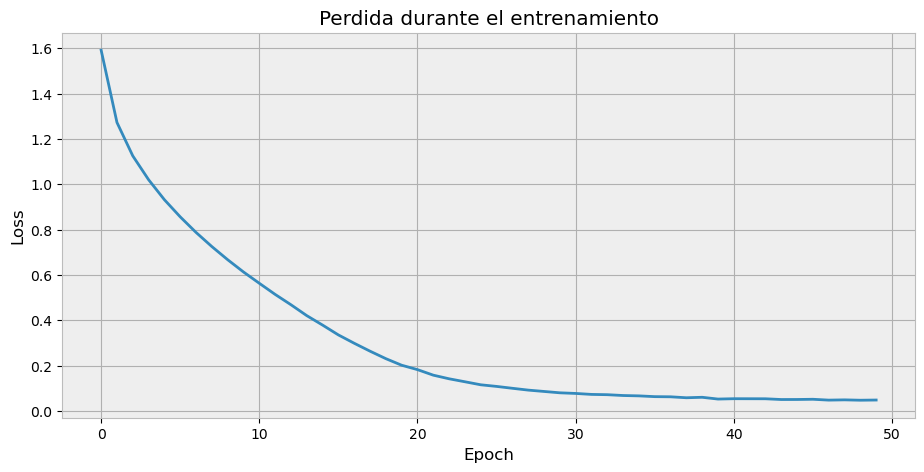

In [6]:
import torch.optim as optim

RedCIFAR=CIFAR_NET()

# Definimos el criterio de perdida (entropia cruzada) y el optimizador (Adam)
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR.parameters(), lr=0.0001)

# Preprocesamiento necesario si se va a usar CUDA (GPU)
cuda = True  
if cuda and torch.cuda.is_available(): # Cambia a False si no tenemos una GPU disponible
    RedCIFAR.cuda()

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(50,trainloader,criterio,optimizer,cuda=cuda) 

# Esta celda con estas especificaciones tarda en ejecutarse 54 minutos

In [7]:
# prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_train = calcularPrecisionGlobal(RedCIFAR, trainloader, 4, cuda=cuda)

# prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
prec_val = calcularPrecisionGlobal(RedCIFAR, testloader, 4, cuda=cuda)


# print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train),cuda=cuda)
print("Precision en conjunto de entrenamiento: %.4f%%" % prec_train)

#print("Precision en conjunto de validacion: %.4f%%"%(prec_val),cuda=cuda)
print("Precision en conjunto de validacion: %.4f%%" % prec_val)

# Guardamos el modelo
torch.save(RedCIFAR.state_dict(), 'CIFAR10_model.pth')

Precision en conjunto de entrenamiento: 99.0880%
Precision en conjunto de validacion: 70.2300%


## Ejercicios:
* Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve. Muestra la imagen con la que se está alimentando a la red.
* Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles. Para ello en lugar de tener en cuenta únicamente los valores de verdaderos positivos, verdaderos negativos, etc, se usarán los 10 elementos, por lo que debemos tener en cuenta cuantos de cada categoria fueron clasificados incorrectamente, y en cual fue.
* Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.

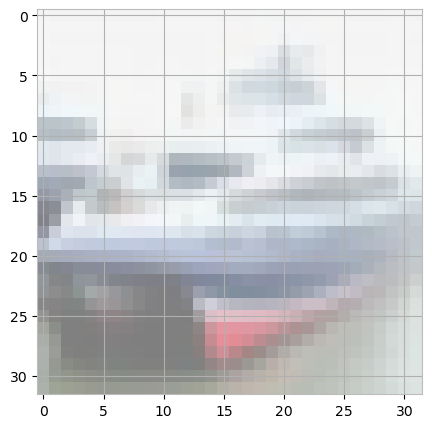

Prediccion: ship
Etiqueta real: ship


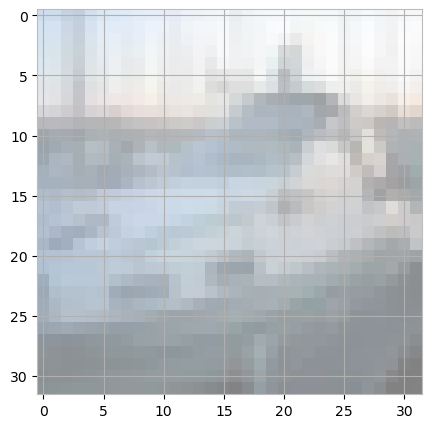

Prediccion: ship
Etiqueta real: ship


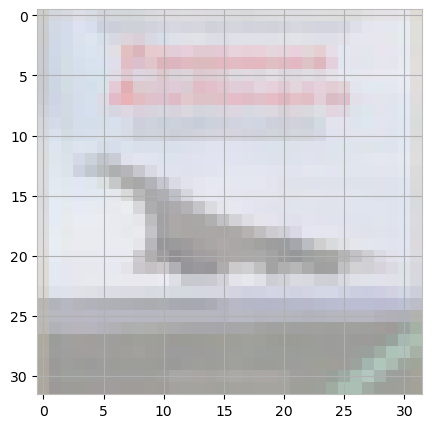

Prediccion: plane
Etiqueta real: plane


In [8]:

def mostrarImagen(image):
    '''
    Muestra una imagen en formato tensor.
    '''
    image = image / 2 + 0.5     # Desnormalizamos
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def predecirImagen(image, net, cuda=False):
    '''
    Dada una imagen, la red y si se va a utilizar CUDA, muestra la imagen y la prediccion de la red.
    '''
    mostrarImagen(image)
    if(cuda and torch.cuda.is_available()):
        image = image.cuda()
    image = Variable(image)
    output = net(image)
    _, predicted = torch.max(output, 1)
    print('Prediccion: %s' % classes[predicted.item()])

# Obtenemos un batch de datos de test
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# Mostramos las imagenes y sus predicciones
#for i in range(4):
#    predecirImagen(images[i], RedCIFAR, cuda=cuda)
#    print('Etiqueta real: %s' % classes[labels[i]])

# Guardamos el modelo
# torch.save(RedCIFAR.state_dict(), 'CIFAR10_model.pth')

# Cargamos el modelo
RedCIFAR = CIFAR_NET()

# Si estamos utilizando CUDA, movemos la red a la GPU
if cuda and torch.cuda.is_available():
    RedCIFAR = RedCIFAR.cuda()

# Cargamos los pesos
RedCIFAR.load_state_dict(torch.load('CIFAR10_model.pth'))



# Mostramos la imagen y sus prediccion
predecirImagen(images[1], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[1]])


# Mostramos la imagen y sus prediccion
predecirImagen(images[2], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[2]])

# Mostramos la imagen y sus prediccion
predecirImagen(images[3], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[3]])





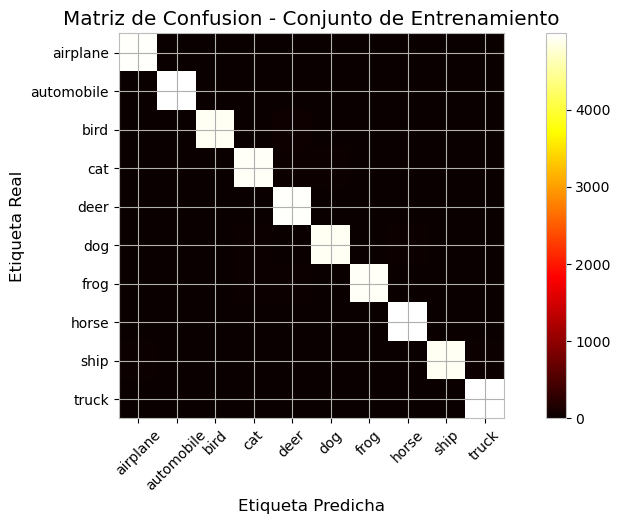

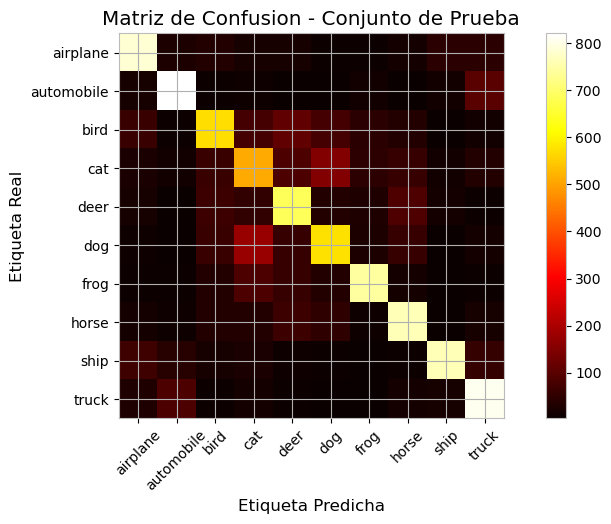

In [9]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def calcularMatrizConfusion(net,data_loader,batch_size,func=None,cuda=False):
    '''
    Calcula la matriz de confusion de una red dada un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario.
    '''
    # Inicializamos la matriz de confusion
    confusion = torch.zeros(10, 10)
    for (images, labels) in data_loader:
        if cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        if func is not None:
            images = func(images)
        salidas = net(images)
        respuestas = salidas.max(dim=1)[1]
        for i in range(len(labels)):
            confusion[labels[i]][respuestas[i]] += 1
    return confusion


# Caluclamos la matriz de confusion de el conjunto de entrenamiento
confusion0 = calcularMatrizConfusion(RedCIFAR, trainloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion0)

# Mostramos la matriz de confusion de el conjunto de entrenamiento
plt.imshow(confusion0, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Entrenamiento')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()


# -------------------------------------------------------------------------------

# Calculamos la matriz de confusion de el conjunto de prueba
confusion = calcularMatrizConfusion(RedCIFAR, testloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion)

# Mostramos la matriz de confusion de el conjunto de prueba
plt.imshow(confusion, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Prueba')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()




### **Conclusiones** 

Como podemos notar, en la matriz de confusion de el entrenamiento/prueba, pudimos visualizar mejor los resultados obtenidos en la precision de el modelo, notese como es que en la parte de entrenamiento el modelo pudo predecir con una buena efectividad del 99.0880% las imagenes y sus clases, sin embargo en la parte de prueba, el modelo no tuvo un rendimiento tan bueno como el anterior, ya que solo pudo predecir con una efectividad del 
70.2300% las imagenes y sus clases, sin emabrgo en este ultimo podemos notar algo curioso, en la parte de los camiones (trucks) la red clasifico la mayor parte como camiones pero otra parte la clasifico como automoviles (automobile), lo cual es hasta cierto punto logico por el parecido entre carros y camiones (esto tambien pasa con los demas vehiculos pero en menor medida), algo similar tambien pasa con los animales, ya que al tener bastantes caracteristicas en comun (en especial los perros y los gatos), la red predijo un buen numero de estos en clases que no les correspondian, sin embargo, en general, el modelo tuvo un rendimiento aceptable en la clasificacion de las imagenes de CIFAR-10, ya que si bien tuvimos cosas como las anteriores, notese como es que nuestro modelo no confundio a cualquier tipo de vehiculo con un animal o viceversa, lo cual es un buen indicativo de que el modelo esta aprendiendo correctamente las caracteristicas de las imagenes y que probablemente con mas entrenamiento o ajustes podriamos mejorar su rendimiento.


[![](https://media1.tenor.com/m/EUD6oQFbpVoAAAAd/chipi-chipi-chapa-chapa.gif)](https://www.youtube.com/watch?v=dQw4w9WgXcQ)
     


Epoch 1, loss: 1.681
Epoch 2, loss: 1.413
Epoch 3, loss: 1.308
Epoch 4, loss: 1.240
Epoch 5, loss: 1.191
Epoch 6, loss: 1.149
Epoch 7, loss: 1.120
Epoch 8, loss: 1.083
Epoch 9, loss: 1.054
Epoch 10, loss: 1.031
Epoch 11, loss: 1.018
Epoch 12, loss: 0.994
Epoch 13, loss: 0.978
Epoch 14, loss: 0.960
Epoch 15, loss: 0.943
Epoch 16, loss: 0.927
Epoch 17, loss: 0.917
Epoch 18, loss: 0.909
Epoch 19, loss: 0.895
Epoch 20, loss: 0.876
Epoch 21, loss: 0.871
Epoch 22, loss: 0.857
Epoch 23, loss: 0.847
Epoch 24, loss: 0.843
Epoch 25, loss: 0.826
Epoch 26, loss: 0.821
Epoch 27, loss: 0.812
Epoch 28, loss: 0.799
Epoch 29, loss: 0.800
Epoch 30, loss: 0.789


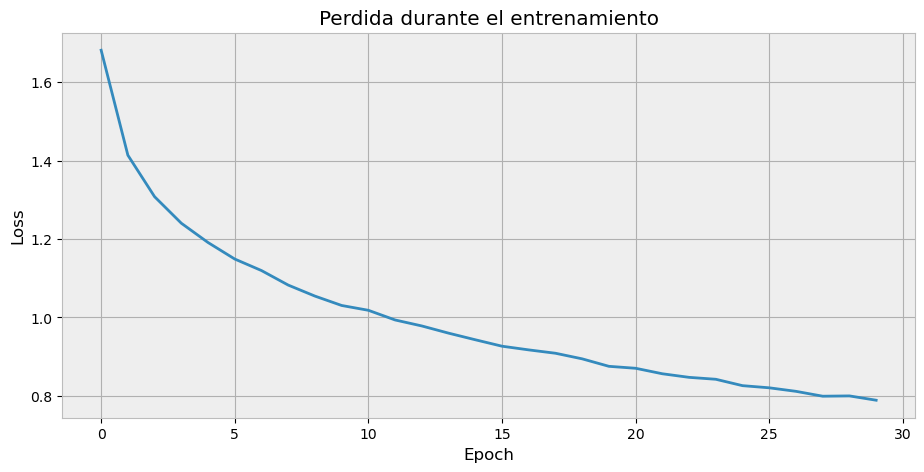

Precision en conjunto de entrenamiento: 74.5340%
Precision en conjunto de validacion: 65.6300%


In [30]:
# Normalización por lotes
# Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red. 
# Realiza la prueba usando normalización por lotes

class CIFAR_NET_BN(nn.Module):
    def __init__(self):
        '''
        Construccion de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET_BN, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        # Conectamos las capas 
        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  # 10 clases en CIFAR-10

        # Normalización por lotes
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(384)
        self.bn4 = nn.BatchNorm1d(192)

    def forward(self, x):
        '''
        Define el orden con el que se realizara la propagacion hacia adelante
        de la red.
        '''
        # Capa convolucional 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Capa convolucional 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Capa conectada 1
        x = x.view(-1, 32 * 5 * 5) # Aplanamos el tensor de la salida de la capa convolucional
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Capa conectada 2
        x = self.fc2(x)
        x = self.bn4(x)
        x = F.relu(x)

        # Capa conectada 3
        x = self.fc3(x)

        return x
    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una funcion de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza tambien el caso 
        en que se llegue a utilizar cuda. Muestra una grafica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        # Lista para almacenar las perdidas durante el entrenamiento
        losses = []

        # Si tenemos disponible una GPU, movemos la red a la GPU
        if(cuda and torch.cuda.is_available()):
            self.cuda()
        
        # Iteramos sobre el numero de epocas
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                # Obtenemos los datos y los movemos a la GPU si es necesario
                inputs, labels = data
                if(cuda and torch.cuda.is_available()):
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Reseteamos los gradientes
                optimizer.zero_grad()

                # Propagacion hacia adelante
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                # Propagacion hacia atras y optimizacion
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                '''
                if i % 2000 == 1999:  
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                '''
                '''
                if i % 2000 == 1999:    # Imprimimos cada 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    losses.append(running_loss)
                    running_loss = 0.0
                '''

            # Guardamos la perdida promedio del epoch
            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.3f' % (epoch + 1, epoch_loss))
        
        # Graficamos las perdidas
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()

# Creamos la red
RedCIFAR_BN = CIFAR_NET_BN()

# Definimos el criterio de perdida (entropia cruzada), el optimizador (Adam) y el learning rate (0.0001)
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR_BN.parameters(), lr=0.00009)

# Preprocesamiento necesario si se va a usar CUDA (GPU)
cuda = True

if cuda and torch.cuda.is_available(): # Cambia a False si no tenemos una GPU disponible
    RedCIFAR_BN.cuda()

# Entrenamos la red durante 30 pasos ,con entropia cruzada y el optimizador
RedCIFAR_BN.train(30, trainloader, criterio, optimizer, cuda=cuda)

# prec_train =calcularPrecisionGlobal(RedCIFAR_BN,trainloader,4)
prec_train = calcularPrecisionGlobal(RedCIFAR_BN, trainloader, 4, cuda=cuda)

# prec_val   =calcularPrecisionGlobal(RedCIFAR_BN,testloader,4)
prec_val = calcularPrecisionGlobal(RedCIFAR_BN, testloader, 4, cuda=cuda)

# print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train),cuda=cuda)
print("Precision en conjunto de entrenamiento: %.4f%%" % prec_train)

# print("Precision en conjunto de validacion: %.4f%%"%(prec_val),cuda=cuda)
print("Precision en conjunto de validacion: %.4f%%" % prec_val)

# Guardamos el modelo
torch.save(RedCIFAR_BN.state_dict(), 'CIFAR10_model_BN.pth')

# Esta celda con estas especificaciones tarda en ejecutarse 43 minutos

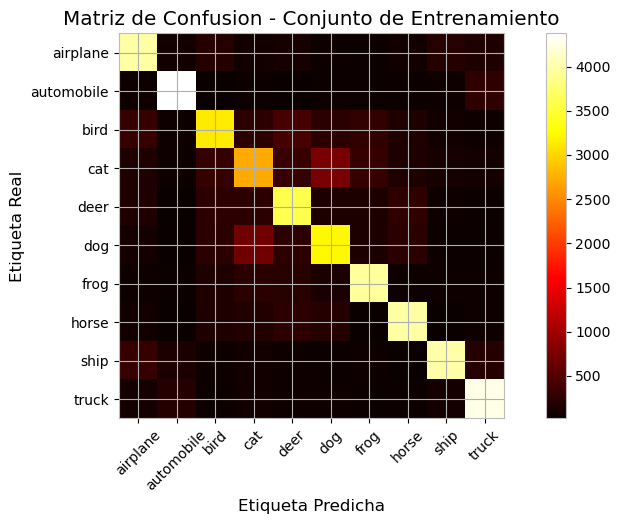

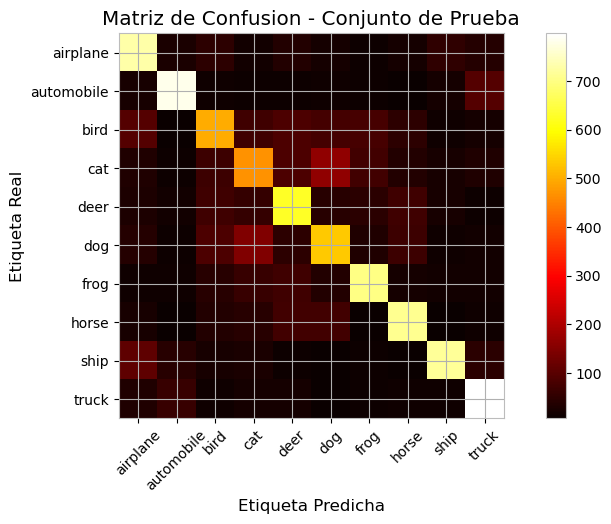

In [32]:
# Cargamos el modelo
RedCIFAR_BN = CIFAR_NET_BN()

# Si estamos utilizando CUDA, movemos la red a la GPU
if cuda and torch.cuda.is_available():
    RedCIFAR_BN = RedCIFAR_BN.cuda()

# Cargamos los pesos
RedCIFAR_BN.load_state_dict(torch.load('CIFAR10_model_BN.pth'))

# Obtenemos un batch de datos de test
dataiter = iter(testloader)


# Calculamos la matriz de confusion de el conjunto de entrenamiento
confusion00 = calcularMatrizConfusion(RedCIFAR_BN, trainloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion0)

# Mostramos la matriz de confusion de el conjunto de entrenamiento
plt.imshow(confusion00, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Entrenamiento')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()

# Calculamos la matriz de confusion de el conjunto de prueba
confusion11 = calcularMatrizConfusion(RedCIFAR_BN, testloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion)

# Mostramos la matriz de confusion de el conjunto de prueba
plt.imshow(confusion11, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Prueba')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()

### **Conclusiones 2.0** 

Ahora que hemos repetido el proceso para la red con normalizacion, podemos notar que los resultados fueron **casi** los mismos ya que si solo nos basaramos en los porcentajes, veriamos que la red sin normalizar aprendio mejor pero, cuando vemos las matrices de confusion podemos notar que esta nueva red tuvo un mejor rendimiento para poder identificar camiones de carros, lo mismo para las aves y los aviones, sin embargo el reconocimiento de annimales (especialmente perros y gatos) sigue siendo el talon de aquiles de nuestro modelo, nuevamente, si cambiaramos parametros como el lr, el optimizador o el numero de epochs, podriamos tener mejores resultados sobre las redes trabajadas en este notebook.


[![](https://media1.tenor.com/m/ZAMoMuQgf9UAAAAd/mapache-pedro.gif)](https://www.youtube.com/watch?v=dQw4w9WgXcQ)
     


Referencias:

* Krizhevsky , Nair , Hinton. CIFAR-10. https://www.cs.toronto.edu/~kriz/cifar.html
* Pytorch, TORCH.NN, https://pytorch.org/docs/stable/nn.html
* Goodfellow-et-al. (2016). Deep Learning. MIT Press. https://www.deeplearningbook.org/contents/convnets.html

In [10]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()